# Objectives:

Given a particular time and region we need to predict taxi demand in newyork city in next 10 minutes.

# Loading Libraries 

In [13]:
import dask.dataframe as dd
import pandas as pd
import folium
import datetime
import time
import numpy as np
import matplotlib
# matplotlib.use('nbagg') : matplotlib uses this protocall which makes plots more user intractive like zoom in and zoom out
matplotlib.use('nbagg')
import matplotlib.pylab as plt
import seaborn as sns
from matplotlib import rcParams
# this lib is used while we calculate the stight line distance between two (lat,lon) pairs in miles
import gpxpy.geo #Get the haversine distance
from sklearn.cluster import MiniBatchKMeans, KMeans
import math
import pickle
import os
import xgboost as xgb

# to install sklearn: pip install -U scikit-learn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Looking at the features
# dask dataframe  : # https://github.com/dask/dask-tutorial/blob/master/07_dataframe.ipynb
month = dd.read_csv('yellow_tripdata_2015-01.csv')
print(month.columns)

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RateCodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')


In [3]:
month.head(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,N,-73.974785,40.750618,1,12.0,1.0,0.5,3.25,0.0,0.3,17.05
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,N,-73.994415,40.759109,1,14.5,0.5,0.5,2.00,0.0,0.3,17.80
2,1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1,N,-73.951820,40.824413,2,9.5,0.5,0.5,0.00,0.0,0.3,10.80
3,1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1,N,-74.004326,40.719986,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80
4,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1,N,-74.004181,40.742653,2,15.0,0.5,0.5,0.00,0.0,0.3,16.30


# Data Cleaning

#### Pickup Latitude and Pickup Longitude

In [27]:
# Plotting pickup cordinates which are outside the bounding box of New-York 
# we will collect all the points outside the bounding box of newyork city to outlier_locations
outlier_locations = month[((month.pickup_longitude <= -74.15) | (month.pickup_latitude <= 40.5774)| \
                   (month.pickup_longitude >= -73.7004) | (month.pickup_latitude >= 40.9176))]

# creating a map with the a base location
# read more about the folium here: http://folium.readthedocs.io/en/latest/quickstart.html

# note: you dont need to remember any of these, you dont need indeepth knowledge on these maps and plots

map_osm = folium.Map(location=[40.734695, -73.990372], zoom_start=12,tiles='Stamen Toner')


# we will spot only first 100 outliers on the map, plotting all the outliers will take more time
sample_locations = outlier_locations.head(1000)
for i,j in sample_locations.iterrows():
    if int(j['pickup_latitude']) != 0:
        folium.Marker(list((j['pickup_latitude'],j['pickup_longitude']))).add_to(map_osm)
map_osm

#### Dropoff Latitude & Dropoff Longitude

In [29]:
# Plotting dropoff cordinates which are outside the bounding box of New-York 
# we will collect all the points outside the bounding box of newyork city to outlier_locations
outlier_locations = month[((month.dropoff_longitude <= -74.15) | (month.dropoff_latitude <= 40.5774)| \
                   (month.dropoff_longitude >= -73.7004) | (month.dropoff_latitude >= 40.9176))]

# creating a map with the a base location
# read more about the folium here: http://folium.readthedocs.io/en/latest/quickstart.html

# note: you dont need to remember any of these, you dont need indeepth knowledge on these maps and plots

map_osm = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')

# we will spot only first 100 outliers on the map, plotting all the outliers will take more time
sample_locations = outlier_locations.head(1000)
for i,j in sample_locations.iterrows():
    if int(j['pickup_latitude']) != 0:
        folium.Marker(list((j['dropoff_latitude'],j['dropoff_longitude']))).add_to(map_osm)
map_osm

# Analyzing Trip Durations:

In [4]:
#The timestamps are converted to unix so as to get duration(trip-time) & speed also pickup-times in unix are used while binning 

# in out data we have time in the formate "YYYY-MM-DD HH:MM:SS" we convert thiss sting to python time formate and then into unix time stamp
# https://stackoverflow.com/a/27914405
def convert_to_unix(s):
    return time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S").timetuple())

def return_with_trip_times(month):
    duration = month[['tpep_pickup_datetime','tpep_dropoff_datetime']].compute()
    #pickups and dropoffs to unix time
    duration_pickup = [convert_to_unix(x) for x in duration['tpep_pickup_datetime'].values]
    duration_drop = [convert_to_unix(x) for x in duration['tpep_dropoff_datetime'].values]
    #calculate duration of trips
    durations = (np.array(duration_drop) - np.array(duration_pickup))/float(60)

    #append durations of trips and speed in miles/hr to a new dataframe
    new_frame = month[['passenger_count','trip_distance','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','total_amount']].compute()
    
    new_frame['trip_times'] = durations
    new_frame['pickup_times'] = duration_pickup
    new_frame['Speed'] = 60*(new_frame['trip_distance']/new_frame['trip_times'])
    
    return new_frame


frame_with_durations = return_with_trip_times(month)

<IPython.core.display.Javascript object>


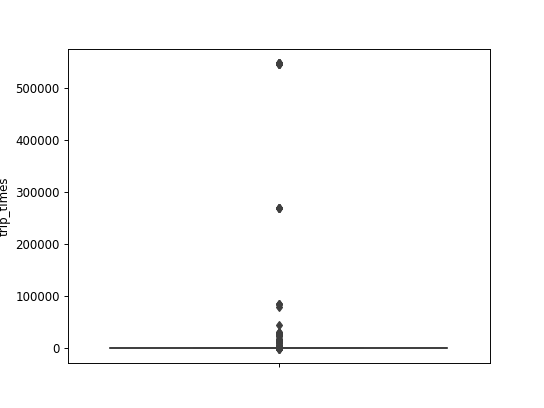

In [5]:
# the skewed box plot shows us the presence of outliers 
sns.boxplot(y="trip_times", data =frame_with_durations)
plt.show()

In [6]:
#calculating 0-100th percentile to find a the correct percentile value for removal of outliers
for i in range(0,100,10):
    var =frame_with_durations["trip_times"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

0 percentile value is -1211.0166666666667
10 percentile value is 3.8333333333333335
20 percentile value is 5.383333333333334
30 percentile value is 6.816666666666666
40 percentile value is 8.3
50 percentile value is 9.95
60 percentile value is 11.866666666666667
70 percentile value is 14.283333333333333
80 percentile value is 17.633333333333333
90 percentile value is 23.45
100 percentile value is  548555.6333333333


In [7]:
#looking further from the 99th percecntile
for i in range(90,100):
    var =frame_with_durations["trip_times"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

90 percentile value is 23.45
91 percentile value is 24.35
92 percentile value is 25.383333333333333
93 percentile value is 26.55
94 percentile value is 27.933333333333334
95 percentile value is 29.583333333333332
96 percentile value is 31.683333333333334
97 percentile value is 34.46666666666667
98 percentile value is 38.71666666666667
99 percentile value is 46.75
100 percentile value is  548555.6333333333


In [8]:
#removing data based on our analysis and TLC regulations
frame_with_durations_modified=frame_with_durations[(frame_with_durations.trip_times>1) & (frame_with_durations.trip_times<720)]

<IPython.core.display.Javascript object>


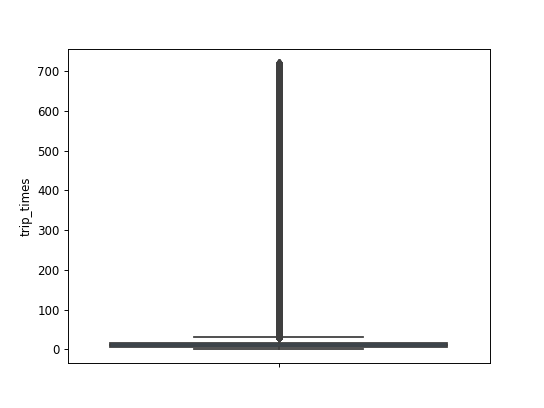

In [9]:
#box-plot after removal of outliers
sns.boxplot(y="trip_times", data =frame_with_durations_modified)
plt.show()

<IPython.core.display.Javascript object>


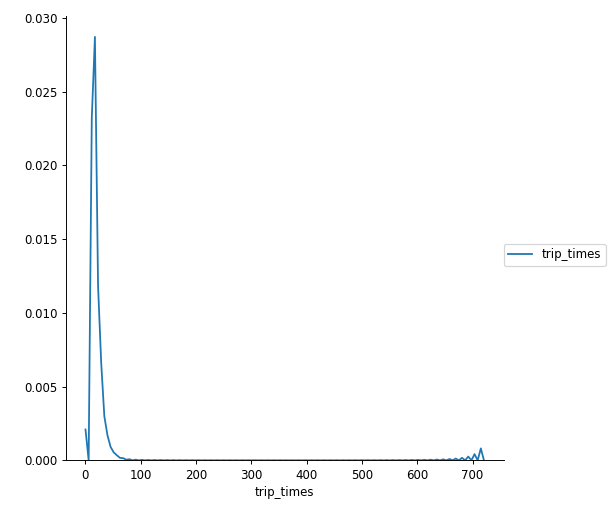

In [10]:
#pdf of trip-times after removing the outliers
sns.FacetGrid(frame_with_durations_modified,size=6) \
      .map(sns.kdeplot,"trip_times") \
      .add_legend();
plt.show();

In [11]:
#converting the values to log-values to chec for log-normal
import math
frame_with_durations_modified['log_times']=[math.log(i) for i in frame_with_durations_modified['trip_times'].values]

<IPython.core.display.Javascript object>


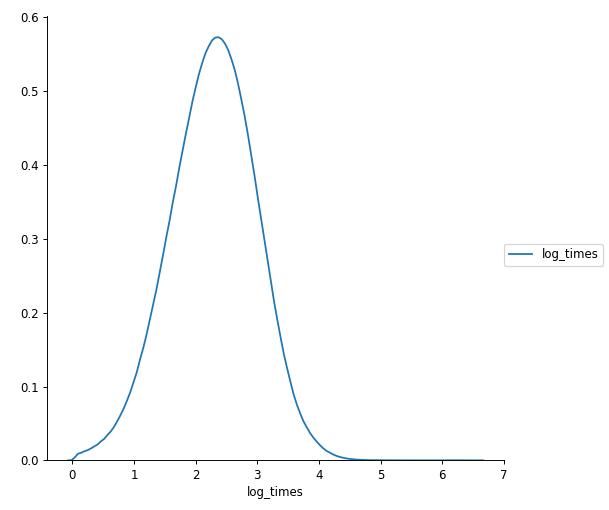

In [12]:
#pdf of log-values
sns.FacetGrid(frame_with_durations_modified,size=6) \
      .map(sns.kdeplot,"log_times") \
      .add_legend();
plt.show();

<IPython.core.display.Javascript object>


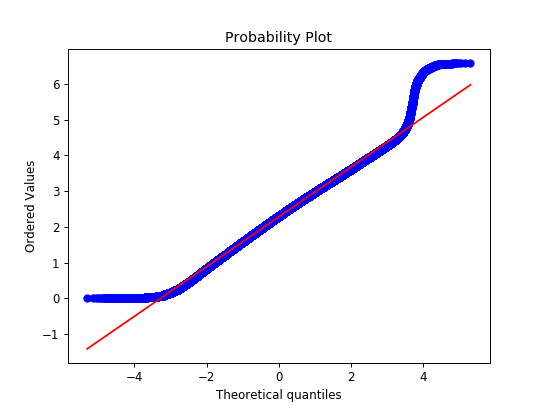

In [13]:
import scipy
#Q-Q plot for checking if trip-times is log-normal
scipy.stats.probplot(frame_with_durations_modified['log_times'].values, plot=plt)
plt.show()

# Analyzing Speed

<IPython.core.display.Javascript object>


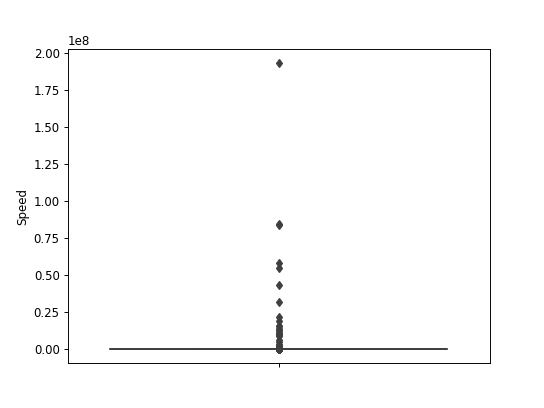

In [14]:
frame_with_durations_modified['Speed'] = 60*(frame_with_durations_modified['trip_distance']/frame_with_durations_modified['trip_times'])
sns.boxplot(y="Speed", data =frame_with_durations_modified)
plt.show()

In [15]:
#calculating speed values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var =frame_with_durations_modified["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 0.0
10 percentile value is 6.409495548961425
20 percentile value is 7.80952380952381
30 percentile value is 8.929133858267717
40 percentile value is 9.98019801980198
50 percentile value is 11.06865671641791
60 percentile value is 12.286689419795222
70 percentile value is 13.796407185628745
80 percentile value is 15.963224893917962
90 percentile value is 20.186915887850468
100 percentile value is  192857142.85714284


In [16]:
#calculating speed values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    var =frame_with_durations_modified["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 20.186915887850468
91 percentile value is 20.91645569620253
92 percentile value is 21.752988047808763
93 percentile value is 22.721893491124263
94 percentile value is 23.844155844155843
95 percentile value is 25.182552504038775
96 percentile value is 26.80851063829787
97 percentile value is 28.84304932735426
98 percentile value is 31.591128254580514
99 percentile value is 35.7513566847558
100 percentile value is  192857142.85714284


In [17]:
#calculating speed values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var =frame_with_durations_modified["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 35.7513566847558
99.1 percentile value is 36.31084727468969
99.2 percentile value is 36.91470054446461
99.3 percentile value is 37.588235294117645
99.4 percentile value is 38.33035714285714
99.5 percentile value is 39.17580340264651
99.6 percentile value is 40.15384615384615
99.7 percentile value is 41.338301043219076
99.8 percentile value is 42.86631016042781
99.9 percentile value is 45.3107822410148
100 percentile value is  192857142.85714284


In [18]:
#removing further outliers based on the 99.9th percentile value
frame_with_durations_modified=frame_with_durations[(frame_with_durations.Speed>0) & (frame_with_durations.Speed<45.31)]

In [19]:
#avg.speed of cabs in New-York
sum(frame_with_durations_modified["Speed"]) / float(len(frame_with_durations_modified["Speed"]))

12.450173996027528

# Analyzing Trip Distance

<IPython.core.display.Javascript object>


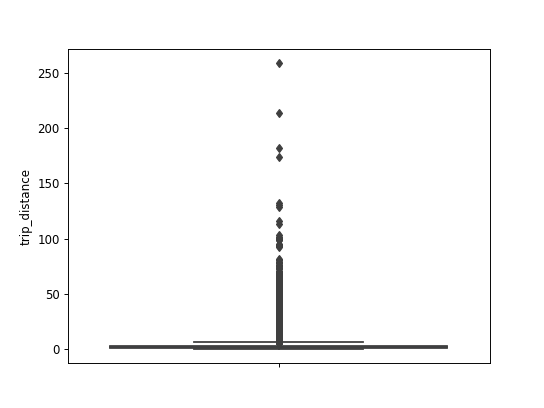

In [20]:
sns.boxplot(y="trip_distance", data =frame_with_durations_modified)
plt.show()

In [21]:
#calculating trip distance values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var =frame_with_durations_modified["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 0.01
10 percentile value is 0.66
20 percentile value is 0.9
30 percentile value is 1.1
40 percentile value is 1.39
50 percentile value is 1.69
60 percentile value is 2.07
70 percentile value is 2.6
80 percentile value is 3.6
90 percentile value is 5.97
100 percentile value is  258.9


In [22]:
#calculating trip distance values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    var =frame_with_durations_modified["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 5.97
91 percentile value is 6.45
92 percentile value is 7.07
93 percentile value is 7.85
94 percentile value is 8.72
95 percentile value is 9.6
96 percentile value is 10.6
97 percentile value is 12.1
98 percentile value is 16.03
99 percentile value is 18.17
100 percentile value is  258.9


In [23]:
#calculating trip distance values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var =frame_with_durations_modified["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 18.17
99.1 percentile value is 18.37
99.2 percentile value is 18.6
99.3 percentile value is 18.83
99.4 percentile value is 19.13
99.5 percentile value is 19.5
99.6 percentile value is 19.96
99.7 percentile value is 20.5
99.8 percentile value is 21.22
99.9 percentile value is 22.57
100 percentile value is  258.9


In [24]:
#removing further outliers based on the 99.9th percentile value
frame_with_durations_modified=frame_with_durations[(frame_with_durations.trip_distance>0) & (frame_with_durations.trip_distance<23)]

<IPython.core.display.Javascript object>


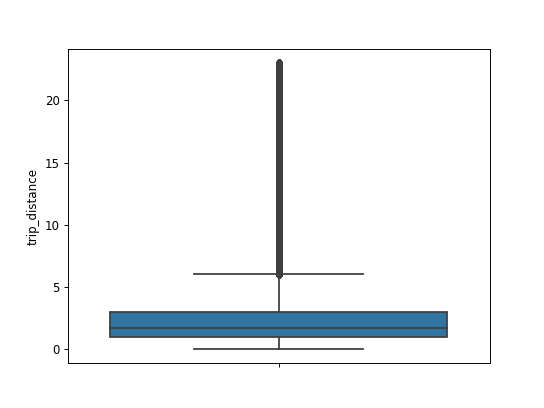

In [25]:
#box-plot after removal of outliers
sns.boxplot(y="trip_distance", data = frame_with_durations_modified)
plt.show()

# Analyzing Total Fare

<IPython.core.display.Javascript object>


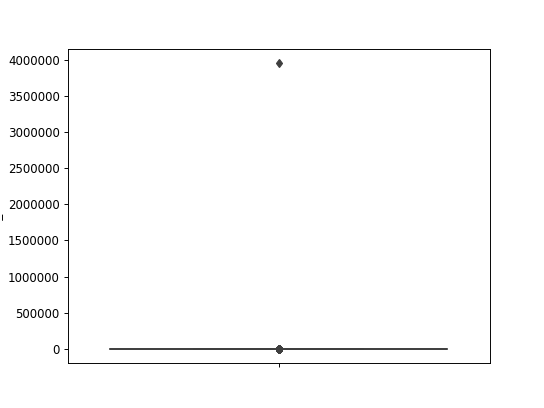

In [26]:
# up to now we have removed the outliers based on trip durations, cab speeds, and trip distances
# lets try if there are any outliers in based on the total_amount
# box-plot showing outliers in fare
sns.boxplot(y="total_amount", data =frame_with_durations_modified)
plt.show()

In [27]:
#calculating total fare amount values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is -242.55
10 percentile value is 6.3
20 percentile value is 7.8
30 percentile value is 8.8
40 percentile value is 9.8
50 percentile value is 11.16
60 percentile value is 12.8
70 percentile value is 14.8
80 percentile value is 18.3
90 percentile value is 25.8
100 percentile value is  3950611.6


In [28]:
#calculating total fare amount values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 25.8
91 percentile value is 27.3
92 percentile value is 29.3
93 percentile value is 31.8
94 percentile value is 34.8
95 percentile value is 38.53
96 percentile value is 42.6
97 percentile value is 48.13
98 percentile value is 58.13
99 percentile value is 66.13
100 percentile value is  3950611.6


In [29]:
#calculating total fare amount values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 66.13
99.1 percentile value is 68.13
99.2 percentile value is 69.6
99.3 percentile value is 69.6
99.4 percentile value is 69.73
99.5 percentile value is 69.75
99.6 percentile value is 69.76
99.7 percentile value is 72.58
99.8 percentile value is 75.35
99.9 percentile value is 88.28
100 percentile value is  3950611.6


<IPython.core.display.Javascript object>


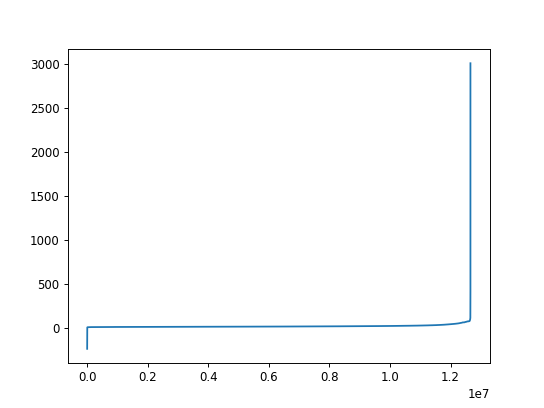

In [30]:
#below plot shows us the fare values(sorted) to find a sharp increase to remove those values as outliers
# plot the fare amount excluding last two values in sorted data
plt.plot(var[:-2])
plt.show()

<IPython.core.display.Javascript object>


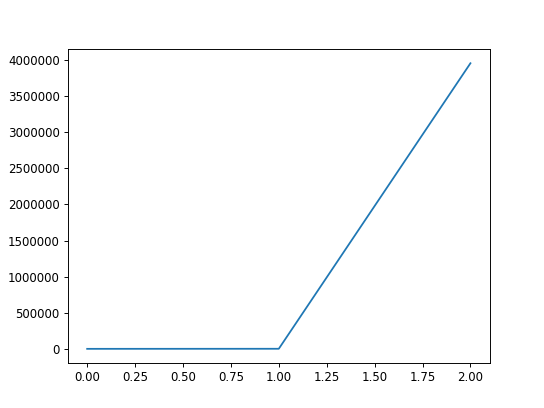

In [31]:
# a very sharp increase in fare values can be seen 
# plotting last three total fare values, and we can observe there is share increase in the values
plt.plot(var[-3:])
plt.show()

<IPython.core.display.Javascript object>


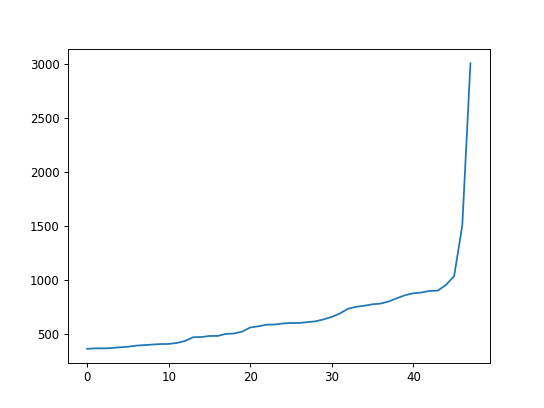

In [32]:
#now looking at values not including the last two points we again find a drastic increase at around 1000 fare value
# we plot last 50 values excluding last two values
plt.plot(var[-50:-2])
plt.show()

# Remove all outliers/erronous points.

In [33]:
#removing all outliers based on our univariate analysis above
def remove_outliers(new_frame):

    
    a = new_frame.shape[0]
    print ("Number of pickup records = ",a)
    temp_frame = new_frame[((new_frame.dropoff_longitude >= -74.15) & (new_frame.dropoff_longitude <= -73.7004) &\
                       (new_frame.dropoff_latitude >= 40.5774) & (new_frame.dropoff_latitude <= 40.9176)) & \
                       ((new_frame.pickup_longitude >= -74.15) & (new_frame.pickup_latitude >= 40.5774)& \
                       (new_frame.pickup_longitude <= -73.7004) & (new_frame.pickup_latitude <= 40.9176))]
    b = temp_frame.shape[0]
    print ("Number of outlier coordinates lying outside NY boundaries:",(a-b))

    
    temp_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 720)]
    c = temp_frame.shape[0]
    print ("Number of outliers from trip times analysis:",(a-c))
    
    
    temp_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 23)]
    d = temp_frame.shape[0]
    print ("Number of outliers from trip distance analysis:",(a-d))
    
    temp_frame = new_frame[(new_frame.Speed <= 65) & (new_frame.Speed >= 0)]
    e = temp_frame.shape[0]
    print ("Number of outliers from speed analysis:",(a-e))
    
    temp_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]
    f = temp_frame.shape[0]
    print ("Number of outliers from fare analysis:",(a-f))
    
    
    new_frame = new_frame[((new_frame.dropoff_longitude >= -74.15) & (new_frame.dropoff_longitude <= -73.7004) &\
                       (new_frame.dropoff_latitude >= 40.5774) & (new_frame.dropoff_latitude <= 40.9176)) & \
                       ((new_frame.pickup_longitude >= -74.15) & (new_frame.pickup_latitude >= 40.5774)& \
                       (new_frame.pickup_longitude <= -73.7004) & (new_frame.pickup_latitude <= 40.9176))]
    
    new_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 720)]
    new_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 23)]
    new_frame = new_frame[(new_frame.Speed < 45.31) & (new_frame.Speed > 0)]
    new_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]
    
    print ("Total outliers removed",a - new_frame.shape[0])
    print ("---")
    return new_frame

In [34]:
print ("Removing outliers in the month of Jan-2015")
print ("----")
frame_with_durations_outliers_removed = remove_outliers(frame_with_durations)
print("fraction of data points that remain after removing outliers", float(len(frame_with_durations_outliers_removed))/len(frame_with_durations))

Removing outliers in the month of Jan-2015
----
Number of pickup records =  12748986
Number of outlier coordinates lying outside NY boundaries: 293919
Number of outliers from trip times analysis: 23889
Number of outliers from trip distance analysis: 92597
Number of outliers from speed analysis: 24473
Number of outliers from fare analysis: 5275
Total outliers removed 377910
---
fraction of data points that remain after removing outliers 0.9703576425607495


# Data-preperation

In [35]:
#trying different cluster sizes to choose the right K in K-means
coords = frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']].values
neighbours=[]

def find_min_distance(cluster_centers, cluster_len):
    nice_points = 0
    wrong_points = 0
    less2 = []
    more2 = []
    min_dist=1000
    for i in range(0, cluster_len):
        nice_points = 0
        wrong_points = 0
        for j in range(0, cluster_len):
            if j!=i:
                distance = gpxpy.geo.haversine_distance(cluster_centers[i][0], cluster_centers[i][1],cluster_centers[j][0], cluster_centers[j][1])
                min_dist = min(min_dist,distance/(1.60934*1000))
                if (distance/(1.60934*1000)) <= 2:
                    nice_points +=1
                else:
                    wrong_points += 1
        less2.append(nice_points)
        more2.append(wrong_points)
    neighbours.append(less2)
    print ("On choosing a cluster size of ",cluster_len,"\nAvg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2):", np.ceil(sum(less2)/len(less2)), "\nAvg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2):", np.ceil(sum(more2)/len(more2)),"\nMin inter-cluster distance = ",min_dist,"\n---")

def find_clusters(increment):
    kmeans = MiniBatchKMeans(n_clusters=increment, batch_size=10000,random_state=42).fit(coords)
    frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])
    cluster_centers = kmeans.cluster_centers_
    cluster_len = len(cluster_centers)
    return cluster_centers, cluster_len

# we need to choose number of clusters so that, there are more number of cluster regions 
#that are close to any cluster center
# and make sure that the minimum inter cluster should not be very less
for increment in range(10, 100, 10):
    cluster_centers, cluster_len = find_clusters(increment)
    find_min_distance(cluster_centers, cluster_len)  

On choosing a cluster size of  10 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 2.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 8.0 
Min inter-cluster distance =  1.0945442325142543 
---
On choosing a cluster size of  20 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 4.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 16.0 
Min inter-cluster distance =  0.7131298007387813 
---
On choosing a cluster size of  30 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 8.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 22.0 
Min inter-cluster distance =  0.5185088176172206 
---
On choosing a cluster size of  40 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 8.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 32.0 
Min inter-cluster distance 

In [36]:
# if check for the 50 clusters you can observe that there are two clusters with only 0.3 miles apart from each other
# so we choose 40 clusters for solve the further problem

# Getting 40 clusters using the kmeans 
kmeans = MiniBatchKMeans(n_clusters=40, batch_size=10000,random_state=0).fit(coords)
frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])

# Time-binning

In [37]:
def add_pickup_bins(frame,month,year):
    unix_pickup_times=[i for i in frame['pickup_times'].values]
    unix_times = [[1420070400,1422748800,1425168000,1427846400,1430438400,1433116800],\
                    [1451606400,1454284800,1456790400,1459468800,1462060800,1464739200]]
    
    start_pickup_unix=unix_times[year-2015][month-1]
    # https://www.timeanddate.com/time/zones/est
    # (int((i-start_pickup_unix)/600)+33) : our unix time is in gmt to we are converting it to est
    tenminutewise_binned_unix_pickup_times=[(int((i-start_pickup_unix)/600)+33) for i in unix_pickup_times]
    frame['pickup_bins'] = np.array(tenminutewise_binned_unix_pickup_times)
    return frame

In [38]:
# clustering, making pickup bins and grouping by pickup cluster and pickup bins
frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])
jan_2015_frame = add_pickup_bins(frame_with_durations_outliers_removed,1,2015)
jan_2015_groupby = jan_2015_frame[['pickup_cluster','pickup_bins','trip_distance']].groupby(['pickup_cluster','pickup_bins']).count()

In [39]:
jan_2015_frame.head()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,trip_times,pickup_times,Speed,pickup_cluster,pickup_bins
0,1,1.59,-73.993896,40.750111,-73.974785,40.750618,17.05,18.050000,1.421329e+09,5.285319,34,2130
1,1,3.30,-74.001648,40.724243,-73.994415,40.759109,17.80,19.833333,1.420902e+09,9.983193,2,1419
2,1,1.80,-73.963341,40.802788,-73.951820,40.824413,10.80,10.050000,1.420902e+09,10.746269,16,1419
3,1,0.50,-74.009087,40.713818,-74.004326,40.719986,4.80,1.866667,1.420902e+09,16.071429,38,1419
4,1,3.00,-73.971176,40.762428,-74.004181,40.742653,16.30,19.316667,1.420902e+09,9.318378,22,1419


In [40]:
jan_2015_groupby.head()

trip_distance
pickup_cluster pickup_bins               
0              1                      105
               2                      199
               3                      208
               4                      141
               5                      155

In [41]:
# Data Preparation for the months of Jan,Feb and March 2016
def datapreparation(month,kmeans,month_no,year_no):
    
    print ("Return with trip times..")

    frame_with_durations = return_with_trip_times(month)
    
    print ("Remove outliers..")
    frame_with_durations_outliers_removed = remove_outliers(frame_with_durations)
    
    print ("Estimating clusters..")
    frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])
    #frame_with_durations_outliers_removed_2016['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed_2016[['pickup_latitude', 'pickup_longitude']])

    print ("Final groupbying..")
    final_updated_frame = add_pickup_bins(frame_with_durations_outliers_removed,month_no,year_no)
    final_groupby_frame = final_updated_frame[['pickup_cluster','pickup_bins','trip_distance']].groupby(['pickup_cluster','pickup_bins']).count()
    
    return final_updated_frame,final_groupby_frame
    
month_jan_2016 = dd.read_csv('yellow_tripdata_2016-01.csv')
month_feb_2016 = dd.read_csv('yellow_tripdata_2016-02.csv')
month_mar_2016 = dd.read_csv('yellow_tripdata_2016-03.csv')

jan_2016_frame,jan_2016_groupby = datapreparation(month_jan_2016,kmeans,1,2016)
feb_2016_frame,feb_2016_groupby = datapreparation(month_feb_2016,kmeans,2,2016)
mar_2016_frame,mar_2016_groupby = datapreparation(month_mar_2016,kmeans,3,2016)

Return with trip times..
Remove outliers..
Number of pickup records =  10906858
Number of outlier coordinates lying outside NY boundaries: 214677
Number of outliers from trip times analysis: 27190
Number of outliers from trip distance analysis: 79742
Number of outliers from speed analysis: 21047
Number of outliers from fare analysis: 4991
Total outliers removed 297784
---
Estimating clusters..
Final groupbying..
Return with trip times..
Remove outliers..
Number of pickup records =  11382049
Number of outlier coordinates lying outside NY boundaries: 223161
Number of outliers from trip times analysis: 27670
Number of outliers from trip distance analysis: 81902
Number of outliers from speed analysis: 22437
Number of outliers from fare analysis: 5476
Total outliers removed 308177
---
Estimating clusters..
Final groupbying..
Return with trip times..
Remove outliers..
Number of pickup records =  12210952
Number of outlier coordinates lying outside NY boundaries: 232444
Number of outliers fro

# Smoothing

In [42]:
# Gets the unique bins where pickup values are present for each each reigion

# for each cluster region we will collect all the indices of 10min intravels in which the pickups are happened
# we got an observation that there are some pickpbins that doesnt have any pickups
def return_unq_pickup_bins(frame):
    values = []
    for i in range(0,40):
        new = frame[frame['pickup_cluster'] == i]
        list_unq = list(set(new['pickup_bins']))
        list_unq.sort()
        values.append(list_unq)
    return values

In [43]:
# for every month we get all indices of 10min intravels in which atleast one pickup got happened

#jan
jan_2015_unique = return_unq_pickup_bins(jan_2015_frame)
jan_2016_unique = return_unq_pickup_bins(jan_2016_frame)

#feb
feb_2016_unique = return_unq_pickup_bins(feb_2016_frame)

#march
mar_2016_unique = return_unq_pickup_bins(mar_2016_frame)

In [44]:
# for each cluster number of 10min intravels with 0 pickups
for i in range(40):
    print("for the ",i,"th cluster number of 10min intavels with zero pickups: ",4464 - len(set(jan_2015_unique[i])))
    print('-'*60)

for the  0 th cluster number of 10min intavels with zero pickups:  41
------------------------------------------------------------
for the  1 th cluster number of 10min intavels with zero pickups:  1986
------------------------------------------------------------
for the  2 th cluster number of 10min intavels with zero pickups:  30
------------------------------------------------------------
for the  3 th cluster number of 10min intavels with zero pickups:  355
------------------------------------------------------------
for the  4 th cluster number of 10min intavels with zero pickups:  38
------------------------------------------------------------
for the  5 th cluster number of 10min intavels with zero pickups:  154
------------------------------------------------------------
for the  6 th cluster number of 10min intavels with zero pickups:  35
------------------------------------------------------------
for the  7 th cluster number of 10min intavels with zero pickups:  34
---------

In [45]:
# Fills a value of zero for every bin where no pickup data is present 
# the count_values: number pickps that are happened in each region for each 10min intravel
# there wont be any value if there are no picksups.
# values: number of unique bins

# for every 10min intravel(pickup_bin) we will check it is there in our unique bin,
# if it is there we will add the count_values[index] to smoothed data
# if not we add 0 to the smoothed data
# we finally return smoothed data
def fill_missing(count_values,values):
    smoothed_regions=[]
    ind=0
    for r in range(0,40):
        smoothed_bins=[]
        for i in range(4464):
            if i in values[r]:
                smoothed_bins.append(count_values[ind])
                ind+=1
            else:
                smoothed_bins.append(0)
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions

In [46]:
# Fills a value of zero for every bin where no pickup data is present 
# the count_values: number pickps that are happened in each region for each 10min intravel
# there wont be any value if there are no picksups.
# values: number of unique bins

# for every 10min intravel(pickup_bin) we will check it is there in our unique bin,
# if it is there we will add the count_values[index] to smoothed data
# if not we add smoothed data (which is calculated based on the methods that are discussed in the above markdown cell)
# we finally return smoothed data
def smoothing(count_values,values):
    smoothed_regions=[] # stores list of final smoothed values of each reigion
    ind=0
    repeat=0 
    smoothed_value=0
    for r in range(0,40):
        smoothed_bins=[] #stores the final smoothed values
        repeat=0
        for i in range(4464):
            if repeat!=0: # prevents iteration for a value which is already visited/resolved
                repeat-=1
                continue
            if i in values[r]: #checks if the pickup-bin exists 
                smoothed_bins.append(count_values[ind]) # appends the value of the pickup bin if it exists
            else:
                if i!=0:
                    right_hand_limit=0
                    for j in range(i,4464):
                        if  j not in values[r]: #searches for the left-limit or the pickup-bin value which has a pickup value
                            continue
                        else:
                            right_hand_limit=j
                            break
                    if right_hand_limit==0:
                    #Case 1: When we have the last/last few values are found to be missing,hence we have no right-limit here
                        smoothed_value=count_values[ind-1]*1.0/((4463-i)+2)*1.0                               
                        for j in range(i,4464):                              
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(4463-i)
                        ind-=1
                    else:
                    #Case 2: When we have the missing values between two known values
                        smoothed_value=(count_values[ind-1]+count_values[ind])*1.0/((right_hand_limit-i)+2)*1.0             
                        for j in range(i,right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(right_hand_limit-i)
                else:
                    #Case 3: When we have the first/first few values are found to be missing,hence we have no left-limit here
                    right_hand_limit=0
                    for j in range(i,4464):
                        if  j not in values[r]:
                            continue
                        else:
                            right_hand_limit=j
                            break
                    smoothed_value=count_values[ind]*1.0/((right_hand_limit-i)+1)*1.0
                    for j in range(i,right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                    repeat=(right_hand_limit-i)
            ind+=1
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions

In [47]:
#Filling Missing values of Jan-2015 with 0
# here in jan_2015_groupby dataframe the trip_distance represents the number of pickups that are happened
jan_2015_fill = fill_missing(jan_2015_groupby['trip_distance'].values,jan_2015_unique)

#Smoothing Missing values of Jan-2015
jan_2015_smooth = smoothing(jan_2015_groupby['trip_distance'].values,jan_2015_unique)

In [48]:
# Jan-2015 data is smoothed, Jan,Feb & March 2016 data missing values are filled with zero
jan_2015_smooth = smoothing(jan_2015_groupby['trip_distance'].values,jan_2015_unique)
jan_2016_smooth = fill_missing(jan_2016_groupby['trip_distance'].values,jan_2016_unique)
feb_2016_smooth = fill_missing(feb_2016_groupby['trip_distance'].values,feb_2016_unique)
mar_2016_smooth = fill_missing(mar_2016_groupby['trip_distance'].values,mar_2016_unique)

# Making list of all the values of pickup data in every bin for a period of 3 months and storing them region-wise 
regions_cum = []

for i in range(0,40):
    regions_cum.append(jan_2016_smooth[4464*i:4464*(i+1)]+feb_2016_smooth[4176*i:4176*(i+1)]+mar_2016_smooth[4464*i:4464*(i+1)])

# Modelling: Baseline Models

In [49]:
#Preparing the Dataframe only with x(i) values as jan-2015 data and y(i) values as jan-2016
ratios_jan = pd.DataFrame()
ratios_jan['Given']=jan_2015_smooth
ratios_jan['Prediction']=jan_2016_smooth
ratios_jan['Ratios']=ratios_jan['Prediction']*1.0/ratios_jan['Given']*1.0

In [50]:
def MA_R_Predictions(ratios,month):
    predicted_ratio=(ratios['Ratios'].values)[0]
    error=[]
    predicted_values=[]
    window_size=3
    predicted_ratio_values=[]
    for i in range(0,4464*40):
        if i%4464==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            predicted_ratio=sum((ratios['Ratios'].values)[(i+1)-window_size:(i+1)])/window_size
        else:
            predicted_ratio=sum((ratios['Ratios'].values)[0:(i+1)])/(i+1)
            
    
    ratios['MA_R_Predicted'] = predicted_values
    ratios['MA_R_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [51]:
def MA_P_Predictions(ratios,month):
    predicted_value=(ratios['Prediction'].values)[0]
    error=[]
    predicted_values=[]
    window_size=1
    predicted_ratio_values=[]
    for i in range(0,4464*40):
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            predicted_value=int(sum((ratios['Prediction'].values)[(i+1)-window_size:(i+1)])/window_size)
        else:
            predicted_value=int(sum((ratios['Prediction'].values)[0:(i+1)])/(i+1))
            
    ratios['MA_P_Predicted'] = predicted_values
    ratios['MA_P_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [52]:
def WA_R_Predictions(ratios,month):
    predicted_ratio=(ratios['Ratios'].values)[0]
    alpha=0.5
    error=[]
    predicted_values=[]
    window_size=5
    predicted_ratio_values=[]
    for i in range(0,4464*40):
        if i%4464==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            sum_values=0
            sum_of_coeff=0
            for j in range(window_size,0,-1):
                sum_values += j*(ratios['Ratios'].values)[i-window_size+j]
                sum_of_coeff+=j
            predicted_ratio=sum_values/sum_of_coeff
        else:
            sum_values=0
            sum_of_coeff=0
            for j in range(i+1,0,-1):
                sum_values += j*(ratios['Ratios'].values)[j-1]
                sum_of_coeff+=j
            predicted_ratio=sum_values/sum_of_coeff
            
    ratios['WA_R_Predicted'] = predicted_values
    ratios['WA_R_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [53]:
def WA_P_Predictions(ratios,month):
    predicted_value=(ratios['Prediction'].values)[0]
    error=[]
    predicted_values=[]
    window_size=2
    for i in range(0,4464*40):
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            sum_values=0
            sum_of_coeff=0
            for j in range(window_size,0,-1):
                sum_values += j*(ratios['Prediction'].values)[i-window_size+j]
                sum_of_coeff+=j
            predicted_value=int(sum_values/sum_of_coeff)

        else:
            sum_values=0
            sum_of_coeff=0
            for j in range(i+1,0,-1):
                sum_values += j*(ratios['Prediction'].values)[j-1]
                sum_of_coeff+=j
            predicted_value=int(sum_values/sum_of_coeff)
    
    ratios['WA_P_Predicted'] = predicted_values
    ratios['WA_P_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [54]:
def EA_R1_Predictions(ratios,month):
    predicted_ratio=(ratios['Ratios'].values)[0]
    alpha=0.6
    error=[]
    predicted_values=[]
    predicted_ratio_values=[]
    for i in range(0,4464*40):
        if i%4464==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        predicted_ratio = (alpha*predicted_ratio) + (1-alpha)*((ratios['Ratios'].values)[i])
    
    ratios['EA_R1_Predicted'] = predicted_values
    ratios['EA_R1_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [55]:
def EA_P1_Predictions(ratios,month):
    predicted_value= (ratios['Prediction'].values)[0]
    alpha=0.3
    error=[]
    predicted_values=[]
    for i in range(0,4464*40):
        if i%4464==0:
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        predicted_value =int((alpha*predicted_value) + (1-alpha)*((ratios['Prediction'].values)[i]))
    
    ratios['EA_P1_Predicted'] = predicted_values
    ratios['EA_P1_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [56]:
mean_err=[0]*10
median_err=[0]*10
ratios_jan,mean_err[0],median_err[0]=MA_R_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[1],median_err[1]=MA_P_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[2],median_err[2]=WA_R_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[3],median_err[3]=WA_P_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[4],median_err[4]=EA_R1_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[5],median_err[5]=EA_P1_Predictions(ratios_jan,'jan')

In [57]:
print ("Error Metric Matrix (Forecasting Methods) - MAPE & MSE")
print ("--------------------------------------------------------------------------------------------------------")
print ("Moving Averages (Ratios) -                             MAPE: ",mean_err[0],"      MSE: ",median_err[0])
print ("Moving Averages (2016 Values) -                        MAPE: ",mean_err[1],"       MSE: ",median_err[1])
print ("--------------------------------------------------------------------------------------------------------")
print ("Weighted Moving Averages (Ratios) -                    MAPE: ",mean_err[2],"      MSE: ",median_err[2])
print ("Weighted Moving Averages (2016 Values) -               MAPE: ",mean_err[3],"      MSE: ",median_err[3])
print ("--------------------------------------------------------------------------------------------------------")
print ("Exponential Moving Averages (Ratios) -              MAPE: ",mean_err[4],"      MSE: ",median_err[4])
print ("Exponential Moving Averages (2016 Values) -         MAPE: ",mean_err[5],"      MSE: ",median_err[5])

Error Metric Matrix (Forecasting Methods) - MAPE & MSE
--------------------------------------------------------------------------------------------------------
Moving Averages (Ratios) -                             MAPE:  0.1821155173392136       MSE:  400.0625504032258
Moving Averages (2016 Values) -                        MAPE:  0.14292849686975506        MSE:  174.84901993727598
--------------------------------------------------------------------------------------------------------
Weighted Moving Averages (Ratios) -                    MAPE:  0.1784869254376018       MSE:  384.01578741039424
Weighted Moving Averages (2016 Values) -               MAPE:  0.13551088436182082       MSE:  162.46707549283155
--------------------------------------------------------------------------------------------------------
Exponential Moving Averages (Ratios) -              MAPE:  0.17783550194861494       MSE:  378.34610215053766
Exponential Moving Averages (2016 Values) -         MAPE:  0.135091526

# Train-Test Split

In [58]:
# Preparing data to be split into train and test, The below prepares data in cumulative form which will be later split into test and train
# number of 10min indices for jan 2015= 24*31*60/10 = 4464
# number of 10min indices for jan 2016 = 24*31*60/10 = 4464
# number of 10min indices for feb 2016 = 24*29*60/10 = 4176
# number of 10min indices for march 2016 = 24*31*60/10 = 4464
# regions_cum: it will contain 40 lists, each list will contain 4464+4176+4464 values which represents the number of pickups 
# that are happened for three months in 2016 data

# print(len(regions_cum))
# 40
# print(len(regions_cum[0]))
# 12960

# we take number of pickups that are happened in last 5 10min intravels
number_of_time_stamps = 5

# output varaible
# it is list of lists
# it will contain number of pickups 13099 for each cluster
output = []


# tsne_lat will contain 13104-5=13099 times lattitude of cluster center for every cluster
# Ex: [[cent_lat 13099times],[cent_lat 13099times], [cent_lat 13099times].... 40 lists]
# it is list of lists
tsne_lat = []


# tsne_lon will contain 13104-5=13099 times logitude of cluster center for every cluster
# Ex: [[cent_long 13099times],[cent_long 13099times], [cent_long 13099times].... 40 lists]
# it is list of lists
tsne_lon = []

# we will code each day 
# sunday = 0, monday=1, tue = 2, wed=3, thur=4, fri=5,sat=6
# for every cluster we will be adding 13099 values, each value represent to which day of the week that pickup bin belongs to
# it is list of lists
tsne_weekday = []

# its an numbpy array, of shape (523960, 5)
# each row corresponds to an entry in out data
# for the first row we will have [f0,f1,f2,f3,f4] fi=number of pickups happened in i+1th 10min intravel(bin)
# the second row will have [f1,f2,f3,f4,f5]
# the third row will have [f2,f3,f4,f5,f6]
# and so on...
tsne_feature = []


tsne_feature = [0]*number_of_time_stamps
for i in range(0,40):
    tsne_lat.append([kmeans.cluster_centers_[i][0]]*13099)
    tsne_lon.append([kmeans.cluster_centers_[i][1]]*13099)
    # jan 1st 2016 is thursday, so we start our day from 4: "(int(k/144))%7+4"
    # our prediction start from 5th 10min intravel since we need to have number of pickups that are happened in last 5 pickup bins
    tsne_weekday.append([int(((int(k/144))%7+4)%7) for k in range(5,4464+4176+4464)])
    # regions_cum is a list of lists [[x1,x2,x3..x13104], [x1,x2,x3..x13104], [x1,x2,x3..x13104], [x1,x2,x3..x13104], [x1,x2,x3..x13104], .. 40 lsits]
    tsne_feature = np.vstack((tsne_feature, [regions_cum[i][r:r+number_of_time_stamps] for r in range(0,len(regions_cum[i])-number_of_time_stamps)]))
    output.append(regions_cum[i][5:])
tsne_feature = tsne_feature[1:]

In [59]:
# Getting the predictions of exponential moving averages to be used as a feature in cumulative form

# upto now we computed 8 features for every data point that starts from 50th min of the day
# 1. cluster center lattitude
# 2. cluster center longitude
# 3. day of the week 
# 4. f_t_1: number of pickups that are happened previous t-1th 10min intravel
# 5. f_t_2: number of pickups that are happened previous t-2th 10min intravel
# 6. f_t_3: number of pickups that are happened previous t-3th 10min intravel
# 7. f_t_4: number of pickups that are happened previous t-4th 10min intravel
# 8. f_t_5: number of pickups that are happened previous t-5th 10min intravel

# from the baseline models we said the exponential weighted moving avarage gives us the best error
# we will try to add the same exponential weighted moving avarage at t as a feature to our data
# exponential weighted moving avarage => p'(t) = alpha*p'(t-1) + (1-alpha)*P(t-1) 
alpha=0.3

# it is a temporary array that store exponential weighted moving avarage for each 10min intravel, 
# for each cluster it will get reset
# for every cluster it contains 13104 values
predicted_values=[]

# it is similar like tsne_lat
# it is list of lists
# predict_list is a list of lists [[x5,x6,x7..x13104], [x5,x6,x7..x13104], [x5,x6,x7..x13104], [x5,x6,x7..x13104], [x5,x6,x7..x13104], .. 40 lsits]
predict_list = []
tsne_flat_exp_avg = []
for r in range(0,40):
    for i in range(0,13104):
        if i==0:
            predicted_value= regions_cum[r][0]
            predicted_values.append(0)
            continue
        predicted_values.append(predicted_value)
        predicted_value =int((alpha*predicted_value) + (1-alpha)*(regions_cum[r][i]))
    predict_list.append(predicted_values[5:])
    predicted_values=[]

In [60]:
# Find weighted average as a feature
# weighted average, weights is a list of weights
def weighted_average(series, weights):
    weighted_avg = []
    for r in range(0,40):
        for i in range(5,13104):
            result = 0.0
            result += (series[r][i] * weights[0] + series[r][i-1] * weights[1] + series[r][i-2] * weights[2] \
                      + series[r][i-3] * weights[3] + series[r][i-4] * weights[4])
            weighted_avg.append(result/5)
    return weighted_avg

In [61]:
weighted_avg = weighted_average(regions_cum, [0.4, 0.3, 0.2, 0.1, 0.1])

In [75]:
weighted_avg[0]

32.18000000000001

In [62]:
# https://grisha.org/blog/2016/02/16/triple-exponential-smoothing-forecasting-part-ii/
# given a series and alpha, return series of smoothed points
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): 
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

double_exp_smt = []
double_exp_smt1 = []
for r in range(0,40):
    double_exp_smt = double_exponential_smoothing(regions_cum[r][1:13104], 0.7, 0.3)
    double_exp_smt1.append(double_exp_smt[5:])

In [63]:
print("size of train data :", int(13099*0.8))
print("size of test data :", int(13099*0.2))

size of train data : 10479
size of test data : 2619


In [64]:
# extracting first 9169 timestamp values i.e 70% of 13099 (total timestamps) for our training data
train_features =  [tsne_feature[i*13099:(13099*i+9169)] for i in range(0,40)]
# temp = [0]*(12955 - 9068)
test_features = [tsne_feature[(13099*(i))+9169:13099*(i+1)] for i in range(0,40)]

In [65]:
# extracting first 9169 timestamp values i.e 70% of 13099 (total timestamps) for our training data
tsne_train_flat_lat = [i[:9169] for i in tsne_lat]
tsne_train_flat_lon = [i[:9169] for i in tsne_lon]
tsne_train_flat_weekday = [i[:9169] for i in tsne_weekday]
tsne_train_flat_output = [i[:9169] for i in output]
tsne_train_flat_exp_avg = [i[:9169] for i in predict_list]
tsne_train_double_exp_smt = [i[:9169] for i in double_exp_smt1]

In [66]:
# extracting the rest of the timestamp values i.e 30% of 12956 (total timestamps) for our test data
tsne_test_flat_lat = [i[9169:] for i in tsne_lat]
tsne_test_flat_lon = [i[9169:] for i in tsne_lon]
tsne_test_flat_weekday = [i[9169:] for i in tsne_weekday]
tsne_test_flat_output = [i[9169:] for i in output]
tsne_test_flat_exp_avg = [i[9169:] for i in predict_list]
tsne_test_double_exp_smt = [i[9169:] for i in double_exp_smt1]

In [67]:
# the above contains values in the form of list of lists (i.e. list of values of each region), here we make all of them in one list
train_new_features = []
for i in range(0,40):
    train_new_features.extend(train_features[i])
test_new_features = []
for i in range(0,40):
    test_new_features.extend(test_features[i])

In [68]:
# converting lists of lists into sinle list i.e flatten
# a  = [[1,2,3,4],[4,6,7,8]]
# print(sum(a,[]))
# [1, 2, 3, 4, 4, 6, 7, 8]

tsne_train_lat = sum(tsne_train_flat_lat, [])
tsne_train_lon = sum(tsne_train_flat_lon, [])
tsne_train_weekday = sum(tsne_train_flat_weekday, [])
tsne_train_output = sum(tsne_train_flat_output, [])
tsne_train_exp_avg = sum(tsne_train_flat_exp_avg,[])
tsne_train_double_exp_smt1 = sum(tsne_train_double_exp_smt,[])

In [69]:
# converting lists of lists into sinle list i.e flatten
# a  = [[1,2,3,4],[4,6,7,8]]
# print(sum(a,[]))
# [1, 2, 3, 4, 4, 6, 7, 8]

tsne_test_lat = sum(tsne_test_flat_lat, [])
tsne_test_lon = sum(tsne_test_flat_lon, [])
tsne_test_weekday = sum(tsne_test_flat_weekday, [])
tsne_test_output = sum(tsne_test_flat_output, [])
tsne_test_exp_avg = sum(tsne_test_flat_exp_avg,[])
tsne_test_double_exp_smt1 = sum(tsne_test_double_exp_smt,[])

In [77]:
# Preparing the data frame for our train data
columns = ['ft_5','ft_4','ft_3','ft_2','ft_1']
df_train = pd.DataFrame(data=train_new_features, columns=columns) 
df_train['lat'] = tsne_train_lat
df_train['lon'] = tsne_train_lon
df_train['weekday'] = tsne_train_weekday
df_train['exp_avg'] = tsne_train_exp_avg
df_train['double_smt'] = tsne_train_double_exp_smt1
df_train['weg_avg'] = weighted_avg[:366760]
print(df_train.shape)

(366760, 11)


In [78]:
# Preparing the data frame for our train data
df_test = pd.DataFrame(data=test_new_features, columns=columns) 
df_test['lat'] = tsne_test_lat
df_test['lon'] = tsne_test_lon
df_test['weekday'] = tsne_test_weekday
df_test['exp_avg'] = tsne_test_exp_avg
df_test['double_smt'] = tsne_test_double_exp_smt1
df_test['weg_avg'] = weighted_avg[366760:]

print(df_test.shape)

(157200, 11)


# Find Features Using Furior Transformation

In [79]:
top_freq_cluster = []
top_ampli_cluster = []
for cluster in range(40):
    count = 0
    top_freq = []
    top_ampli = []
    top_ampli_mean = []
    top_freq_mean = []
    freq = np.fft.fftfreq(len(regions_cum[cluster]), 1)
    for i, j in sorted(enumerate(np.fft.fft(np.array(regions_cum)[cluster][:])), key=lambda x: x[1]):
        top_freq.append(freq[i])
        top_ampli.append(j.real)
        count += 1
        if count == 5:
            break;
    for k in range(13099):
        top_freq_cluster.append(top_freq)
        top_ampli_cluster.append(top_ampli)

In [80]:
df_train_1 = pd.DataFrame(top_freq_cluster[:366760], columns = ('f1', 'f2', 'f3', 'f4', 'f5'))

In [81]:
df_test_1 = pd.DataFrame(top_freq_cluster[366760:], columns = ('f1', 'f2', 'f3', 'f4', 'f5'))

In [82]:
df_train_final = df_train.join(df_train_1)

In [83]:
df_train_final.head()

,ft_5,ft_4,ft_3,ft_2,ft_1,lat,lon,weekday,exp_avg,double_smt,weg_avg,f1,f2,f3,f4,f5
0,0,63,217,189,137,40.776228,-73.982119,4,150,177.016769,32.18,-0.006944,0.006944,0.048611,-0.048611,-0.011905
1,63,217,189,137,135,40.776228,-73.982119,4,139,174.203775,32.02,-0.006944,0.006944,0.048611,-0.048611,-0.011905
2,217,189,137,135,129,40.776228,-73.982119,4,132,181.017084,31.66,-0.006944,0.006944,0.048611,-0.048611,-0.011905
3,189,137,135,129,150,40.776228,-73.982119,4,144,168.567489,32.72,-0.006944,0.006944,0.048611,-0.048611,-0.011905
4,137,135,129,150,164,40.776228,-73.982119,4,158,142.243438,33.28,-0.006944,0.006944,0.048611,-0.048611,-0.011905


In [84]:
df_test_final = df_test.join(df_test_1)

In [85]:
df_test_final.head()

,ft_5,ft_4,ft_3,ft_2,ft_1,lat,lon,weekday,exp_avg,double_smt,weg_avg,f1,f2,f3,f4,f5
0,118,106,104,93,102,40.776228,-73.982119,4,100,116.232411,0.44,-0.000076,0.000076,-0.000534,0.000534,-0.000305
1,106,104,93,102,101,40.776228,-73.982119,4,100,132.630884,0.40,-0.000076,0.000076,-0.000534,0.000534,-0.000305
2,104,93,102,101,120,40.776228,-73.982119,4,114,167.237940,0.36,-0.000076,0.000076,-0.000534,0.000534,-0.000305
3,93,102,101,120,131,40.776228,-73.982119,4,125,167.840090,0.36,-0.000076,0.000076,-0.000534,0.000534,-0.000305
4,102,101,120,131,164,40.776228,-73.982119,4,152,146.004316,0.32,-0.000076,0.000076,-0.000534,0.000534,-0.000305


In [86]:
df_train_2 = pd.DataFrame(top_ampli_cluster[:366760], columns = ('a1', 'a2', 'a3', 'a4', 'a5'))

In [87]:
df_test_2 = pd.DataFrame(top_ampli_cluster[366760:], columns = ('a1', 'a2', 'a3', 'a4', 'a5'))

In [88]:
df_train_final = df_train_final.join(df_train_2)

In [89]:
df_train_final.head()

,ft_5,ft_4,ft_3,ft_2,ft_1,lat,lon,weekday,exp_avg,double_smt,...,f1,f2,f3,f4,f5,a1,a2,a3,a4,a5
0,0,63,217,189,137,40.776228,-73.982119,4,150,177.016769,...,-0.006944,0.006944,0.048611,-0.048611,-0.011905,-194175.951116,-194175.951116,-38139.460074,-38139.460074,-35566.433486
1,63,217,189,137,135,40.776228,-73.982119,4,139,174.203775,...,-0.006944,0.006944,0.048611,-0.048611,-0.011905,-194175.951116,-194175.951116,-38139.460074,-38139.460074,-35566.433486
2,217,189,137,135,129,40.776228,-73.982119,4,132,181.017084,...,-0.006944,0.006944,0.048611,-0.048611,-0.011905,-194175.951116,-194175.951116,-38139.460074,-38139.460074,-35566.433486
3,189,137,135,129,150,40.776228,-73.982119,4,144,168.567489,...,-0.006944,0.006944,0.048611,-0.048611,-0.011905,-194175.951116,-194175.951116,-38139.460074,-38139.460074,-35566.433486
4,137,135,129,150,164,40.776228,-73.982119,4,158,142.243438,...,-0.006944,0.006944,0.048611,-0.048611,-0.011905,-194175.951116,-194175.951116,-38139.460074,-38139.460074,-35566.433486


In [90]:
df_test_final = df_test_final.join(df_test_2)

In [91]:
df_test_final.head()

,ft_5,ft_4,ft_3,ft_2,ft_1,lat,lon,weekday,exp_avg,double_smt,...,f1,f2,f3,f4,f5,a1,a2,a3,a4,a5
0,118,106,104,93,102,40.776228,-73.982119,4,100,116.232411,...,-0.000076,0.000076,-0.000534,0.000534,-0.000305,-317442.368372,-317442.368372,-81336.580738,-81336.580738,-81060.440771
1,106,104,93,102,101,40.776228,-73.982119,4,100,132.630884,...,-0.000076,0.000076,-0.000534,0.000534,-0.000305,-317442.368372,-317442.368372,-81336.580738,-81336.580738,-81060.440771
2,104,93,102,101,120,40.776228,-73.982119,4,114,167.237940,...,-0.000076,0.000076,-0.000534,0.000534,-0.000305,-317442.368372,-317442.368372,-81336.580738,-81336.580738,-81060.440771
3,93,102,101,120,131,40.776228,-73.982119,4,125,167.840090,...,-0.000076,0.000076,-0.000534,0.000534,-0.000305,-317442.368372,-317442.368372,-81336.580738,-81336.580738,-81060.440771
4,102,101,120,131,164,40.776228,-73.982119,4,152,146.004316,...,-0.000076,0.000076,-0.000534,0.000534,-0.000305,-317442.368372,-317442.368372,-81336.580738,-81336.580738,-81060.440771


In [103]:
file = open('tsne_train_output.pkl', 'wb')
pickle.dump(tsne_train_output, file)
file.close()

In [2]:
file = open('tsne_train_output.pkl', 'rb')
tsne_train_output = pickle.load(file)
file.close()

In [104]:
file = open('tsne_test_output.pkl', 'wb')
pickle.dump(tsne_test_output, file)
file.close()

In [3]:
file = open('tsne_test_output.pkl', 'rb')
tsne_test_output = pickle.load(file)
file.close()

In [105]:
file = open('df_train_final.pkl', 'wb')
pickle.dump(df_train_final, file)
file.close()

In [106]:
file = open('df_test_final.pkl', 'wb')
pickle.dump(df_test_final, file)
file.close()

In [4]:
file = open('df_train_final.pkl', 'rb')
df_train_final = pickle.load(file)
file.close()

In [5]:
file = open('df_test_final.pkl', 'rb')
df_test_final = pickle.load(file)
file.close()

In [6]:
def neg_mean_absolute_percentage_error(y_true, y_pred): 
    return (1 - mean_absolute_error(y_true , y_pred)/((sum(y_true)/len(y_true))))

# Linear Regression

In [93]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
model = LinearRegression()
parameters = {'fit_intercept':[True,False], 'normalize':[True,False]}
grid = GridSearchCV(model,parameters, cv=3, scoring=make_scorer(neg_mean_absolute_percentage_error))
grid.fit(df_train_final, tsne_train_output)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'fit_intercept': [True, False], 'normalize': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(neg_mean_absolute_percentage_error), verbose=0)

In [95]:
y_pred = grid.predict(df_test_final)
linear_test_predictions = [round(value) for value in y_pred]
y_pred = grid.predict(df_train_final)
linear_train_predictions = [round(value) for value in y_pred]

In [96]:
train_mape_linear = []
test_mape_linear = []
train_mape_linear.append((mean_absolute_error(tsne_train_output, linear_train_predictions))/(sum(tsne_train_output)/len(tsne_train_output)))
test_mape_linear.append((mean_absolute_error(tsne_test_output, linear_test_predictions))/(sum(tsne_test_output)/len(tsne_test_output)))

In [97]:
train_mape_linear

[0.09512240053588286]

In [98]:
test_mape_linear

[0.0930499753429999]

# Random Forest

In [14]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
# Set the parameters by cross-validation
tuned_parameters = {
'max_depth' : [5,8],
'n_estimators': [100, 200, 500],
'min_samples_split' :[10,15],
'min_samples_leaf' : [1, 2, 5, 10]}
rfc=RandomForestRegressor(random_state=1)
random = RandomizedSearchCV(rfc, tuned_parameters, n_iter = 10,cv=3,verbose = 5,n_jobs=-1,scoring=make_scorer( neg_mean_absolute_percentage_error))
# Fit it to the data
random.fit(df_train_final, tsne_train_output)
# Print the tuned parameter and score


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_estimators=500, min_samples_split=10, min_samples_leaf=10, max_depth=8 
[CV] n_estimators=500, min_samples_split=10, min_samples_leaf=10, max_depth=8 
[CV] n_estimators=500, min_samples_split=10, min_samples_leaf=10, max_depth=8 
[CV] n_estimators=100, min_samples_split=15, min_samples_leaf=1, max_depth=8 
[CV] n_estimators=100, min_samples_split=15, min_samples_leaf=1, max_depth=8 
[CV] n_estimators=100, min_samples_split=15, min_samples_leaf=1, max_depth=8 
[CV] n_estimators=500, min_samples_split=10, min_samples_leaf=5, max_depth=5 
[CV] n_estimators=500, min_samples_split=10, min_samples_leaf=5, max_depth=5 
[CV] n_estimators=500, min_samples_split=10, min_samples_leaf=5, max_depth=5 
[CV] n_estimators=500, min_samples_split=10, min_samples_leaf=5, max_depth=8 
[CV]  n_estimators=100, min_samples_split=15, min_samples_leaf=1, max_depth=8, score=0.901649259470979, total= 2.8min
[CV] n_estimators=500, min_samples_spl

[Parallel(n_jobs=-1)]: Done  18 out of  30 | elapsed: 14.7min remaining:  9.8min


[CV] n_estimators=500, min_samples_split=10, min_samples_leaf=1, max_depth=5 
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_depth=5, score=0.8913971118546687, total= 3.5min
[CV] n_estimators=500, min_samples_split=10, min_samples_leaf=1, max_depth=5 
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_depth=5, score=0.8925008470095076, total= 3.8min
[CV] n_estimators=500, min_samples_split=10, min_samples_leaf=1, max_depth=5 
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=1, max_depth=5, score=0.8927486032033854, total= 1.8min
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=1, max_depth=5, score=0.8912392560519976, total= 1.8min
[CV]  n_estimators=500, min_samples_split=10, min_samples_leaf=5, max_depth=8, score=0.9050687011265932, total=13.8min
[CV]  n_estimators=500, min_samples_split=10, min_samples_leaf=5, max_depth=8, score=0.901935057896211, total=13.8min
[CV]  n_estimators=500, min_samples_split=10, min_sam

[Parallel(n_jobs=-1)]: Done  25 out of  30 | elapsed: 21.2min remaining:  4.2min


[CV]  n_estimators=500, min_samples_split=10, min_samples_leaf=1, max_depth=5, score=0.8913892760201345, total= 7.0min
[CV]  n_estimators=500, min_samples_split=10, min_samples_leaf=1, max_depth=5, score=0.888972250256233, total= 8.5min
[CV]  n_estimators=500, min_samples_split=10, min_samples_leaf=2, max_depth=8, score=0.9019348572810041, total=10.1min
[CV]  n_estimators=500, min_samples_split=10, min_samples_leaf=2, max_depth=8, score=0.9017113559777956, total=10.4min
[CV]  n_estimators=500, min_samples_split=10, min_samples_leaf=2, max_depth=8, score=0.9050455351604514, total=11.6min


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 26.2min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=1, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'max_depth': [5, 8], 'n_estimators': [100, 200, 500], 'min_samples_split': [10, 15], 'min_samples_leaf': [1, 2, 5, 10]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn',
          scoring=make_scorer(neg_mean_absolute_percentage_error),
          verbose=5)

In [15]:
y_pred = random.predict(df_test_final)
random_test_predictions = [round(value) for value in y_pred]
y_pred = random.predict(df_train_final)
random_train_predictions = [round(value) for value in y_pred]

In [16]:
train_mape_random=[]
test_mape_random=[]
train_mape_random.append((mean_absolute_error(tsne_train_output, random_train_predictions))/(sum(tsne_train_output)/len(tsne_train_output)))
test_mape_random.append((mean_absolute_error(tsne_test_output, random_test_predictions))/(sum(tsne_test_output)/len(tsne_test_output)))

In [17]:
train_mape_random

[0.095857815562311724]

In [18]:
test_mape_random

[0.09482489707136002]

# Xgboost

In [22]:
hyper_parameter = {'subsample':[0.7, 0.8, 0.9],
 'min_child_weight':[3, 5],
 'reg_lambda':[100, 200],
 'max_depth': [5,8]}
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
xbgr = xgb.XGBRegressor()
rsearch = RandomizedSearchCV(xbgr, hyper_parameter, n_iter = 10, verbose = 5, scoring=make_scorer(neg_mean_absolute_percentage_error),n_jobs=-1, cv=3)
rsearch.fit(df_train_final, tsne_train_output)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] subsample=0.8, reg_lambda=200, min_child_weight=5, max_depth=8 ..
[CV] subsample=0.8, reg_lambda=200, min_child_weight=5, max_depth=8 ..
[CV] subsample=0.8, reg_lambda=200, min_child_weight=5, max_depth=8 ..
[CV] subsample=0.9, reg_lambda=200, min_child_weight=5, max_depth=8 ..
[CV] subsample=0.9, reg_lambda=200, min_child_weight=5, max_depth=8 ..
[CV] subsample=0.9, reg_lambda=200, min_child_weight=5, max_depth=8 ..
[CV] subsample=0.8, reg_lambda=100, min_child_weight=3, max_depth=5 ..
[CV] subsample=0.8, reg_lambda=100, min_child_weight=3, max_depth=5 ..
[CV] subsample=0.8, reg_lambda=100, min_child_weight=3, max_depth=5 ..
[CV] subsample=0.9, reg_lambda=100, min_child_weight=5, max_depth=5 ..
[CV]  subsample=0.9, reg_lambda=100, min_child_weight=5, max_depth=5, score=0.9026618962889649, total=  48.9s
[CV] subsample=0.9, reg_lambda=100, min_child_weight=5, max_depth=5 ..
[CV]  subsample=0.8, reg_lambda=100, min_child_w

[Parallel(n_jobs=-1)]: Done  18 out of  30 | elapsed:  2.6min remaining:  1.8min


[CV] subsample=0.9, reg_lambda=200, min_child_weight=5, max_depth=5 ..
[CV]  subsample=0.7, reg_lambda=200, min_child_weight=3, max_depth=5, score=0.9025489638072866, total=  58.3s
[CV] subsample=0.9, reg_lambda=200, min_child_weight=5, max_depth=5 ..
[CV]  subsample=0.7, reg_lambda=200, min_child_weight=3, max_depth=5, score=0.9063180304253909, total=  56.4s
[CV] subsample=0.9, reg_lambda=200, min_child_weight=5, max_depth=5 ..
[CV]  subsample=0.7, reg_lambda=200, min_child_weight=3, max_depth=5, score=0.9025709296549635, total=  55.7s
[CV]  subsample=0.8, reg_lambda=200, min_child_weight=3, max_depth=8, score=0.90306256281018, total= 1.5min
[CV]  subsample=0.9, reg_lambda=200, min_child_weight=3, max_depth=5, score=0.9026039846010792, total=  52.2s
[CV]  subsample=0.8, reg_lambda=200, min_child_weight=3, max_depth=8, score=0.9067883037334621, total= 1.5min
[CV]  subsample=0.9, reg_lambda=200, min_child_weight=3, max_depth=5, score=0.9065599101739599, total=  51.8s


[Parallel(n_jobs=-1)]: Done  25 out of  30 | elapsed:  3.4min remaining:   40.7s


[CV]  subsample=0.9, reg_lambda=200, min_child_weight=5, max_depth=5, score=0.902639669100642, total=  47.3s
[CV]  subsample=0.8, reg_lambda=200, min_child_weight=3, max_depth=8, score=0.9028288932962665, total= 1.5min
[CV]  subsample=0.9, reg_lambda=200, min_child_weight=3, max_depth=5, score=0.9024829147804073, total=  55.4s
[CV]  subsample=0.9, reg_lambda=200, min_child_weight=5, max_depth=5, score=0.9065573462909555, total=  35.7s
[CV]  subsample=0.9, reg_lambda=200, min_child_weight=5, max_depth=5, score=0.9026714875488971, total=  35.1s


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  3.6min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'subsample': [0.7, 0.8, 0.9], 'min_child_weight': [3, 5], 'reg_lambda': [100, 200], 'max_depth': [5, 8]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn',
          scoring=make_scorer(neg_mean_absolute_percentage_error),
          verbose=5)

In [23]:
y_pred = rsearch.predict(df_test_final)
xgb_test_predictions = [round(value) for value in y_pred]
y_pred = rsearch.predict(df_train_final)
xgb_train_predictions = [round(value) for value in y_pred]

In [24]:
train_mape_xgb=[]
test_mape_xgb=[]
train_mape_xgb.append((mean_absolute_error(tsne_train_output, xgb_train_predictions))/(sum(tsne_train_output)/len(tsne_train_output)))
test_mape_xgb.append((mean_absolute_error(tsne_test_output, xgb_test_predictions))/(sum(tsne_test_output)/len(tsne_test_output)))

In [25]:
train_mape_xgb

[0.093071675396439443]

In [26]:
test_mape_xgb

[0.092779130620935887]

In [19]:
train_mape=[]
test_mape=[]

train_mape.append((mean_absolute_error(tsne_train_output,df_train_final['ft_1'].values))/(sum(tsne_train_output)/len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output,df_train_final['exp_avg'].values))/(sum(tsne_train_output)/len(tsne_train_output)))
test_mape.append((mean_absolute_error(tsne_test_output, df_test_final['ft_1'].values))/(sum(tsne_test_output)/len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output, df_test_final['exp_avg'].values))/(sum(tsne_test_output)/len(tsne_test_output)))

In [20]:
train_mape

[0.14005275878666593, 0.13289968436017227]

In [21]:
test_mape

[0.13653125704827038, 0.12936180420430524]

# Conclusion


In [28]:
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ["Model", "Train MAPE", "Test MAPE"]
x.add_row(["Baseine Model1", "0.14005275878666593", "0.13653125704827038"])
x.add_row(["Baseine Model2","0.13289968436017227" , " 0.12936180420430524"])
x.add_row(["Linear Regression", "0.09512240053588286", "0.0930499753429999"])
x.add_row(["Random Forest", "0.095857815562311724", "0.09482489707136002"])
x.add_row(["Xgboost", "0.093071675396439443", "0.092779130620935887"])
print(x)

+-------------------+----------------------+----------------------+
|       Model       |      Train MAPE      |      Test MAPE       |
+-------------------+----------------------+----------------------+
|   Baseine Model1  | 0.14005275878666593  | 0.13653125704827038  |
|   Baseine Model2  | 0.13289968436017227  |  0.12936180420430524 |
| Linear Regression | 0.09512240053588286  |  0.0930499753429999  |
|   Random Forest   | 0.095857815562311724 | 0.09482489707136002  |
|      Xgboost      | 0.093071675396439443 | 0.092779130620935887 |
+-------------------+----------------------+----------------------+


# Summary: 


<b style="color:green"> Data Loading: </b>

As the data is huge we will use dask dataframe to load the data efficiently, we will take only one month (jan 2015) data to be used for EDA ,find distribution and outliers. later we can apply to other month data to cleanup and train the model. while looking at the data we have done univariate and bivariate analysis.

<b style="color:green"> EDA: </b>

First of all, we have some domain knowledge about newyork city's lattitude and longitude and car driving rules.
so we can plot the map data using folium and remove outliers(data given outside newyork city).

Analyzing Trip Durations:
                                                                                                    we observed the timestamp given in "YYYY-MM-DD HH:MM:SS" this format. if we could convert to unix EPOCH time, it would be easy for us to find difference between two timestamp. to know more about epoch time please refer to https://en.wikipedia.org/wiki/Unix_time .
Now we can analyze the distribution of data and find if there is any outlier and filter the data.
		
Analyzing Speed: 
        Analyzing spped is important because it is important to know in a unit of time how much distance it can cover and remove data if it is outlier.

Analyzing Trip Distance:
        trip distance also important how much distance a driver cover and how much time it is taking and remove data if any outlier presents.
		
Analyzing Trip Fare:
        plotted the distribution and to find if any outlier and removed it.
		
		
Our intention is to divide the whole newyork city into resonable numbers of region and predict demand of taxies in each regions next 10 minutes.
while dividing the regions we need to be carefull about inter-region distance should not be too small and too large and we found divide the whole city in 40 regions is good enough.Next we need to find what is the number of pickups in each region in every 10 mis. once we have the data ready we can apply base model to find the error. 


<b style="color:green"> Matrices: </b>

This is regression problem. so we can use MSE but it will be difficult to interpreat in this case study rather if we get how much percent error from original would make scense.we will go with MAPE(ean Absolute Percentage Error)

<b style="color:green"> Feature Engineering: </b>

        we have tried multiple timeseries related feature engineering like moving averages, weighted moving averages, exponential moving averages with smoothing for single and double parameters, FFT and extracted important features.
        
<b style="color:green"> Train, Test Split and fit the model: </b>

Once we are done with data processing and preparation stage, we split to data to train and test split and fit the train data to multiple model.It is timeseries data and it is known for its linearity, we tried with linear regression at the first place and as expected it gives good performance. To check the performance of the model we got test data and found linear regression and ensemble models approx. gives 9% error.
        